In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno
sns.set_style("darkgrid")

import matplotlib as mpl

mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["font.size"] = 10

import plotly.graph_objects as go
import plotly.express as px

import os
import gc

os.chdir("./제6회 L.POINT Big Data Competition/")

def resumetable(df):
    print(f"DataSet Shape : {df.shape}")
    summary = pd.DataFrame(df.dtypes, columns={'dtypes'})
    summary = summary.reset_index()
    summary["Name"] = summary["index"]
    summary = summary[["Name","dtypes"]]
    summary['Missing'] = df.isnull().sum().values
    summary['Unique'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, "Entropy"] = round(stats.entropy(df[name].value_counts(normalize = True), base=2),2)
        
    return summary

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

from IPython.core.display import HTML

def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

In [4]:
#online_df = pd.read_csv("merged_onilne_df.csv")
#online_df = reduce_mem_usage(online_df)

Mem. usage decreased to 405.38 Mb (45.8% reduction)


In [2]:
online_df = pd.read_csv("clear_merged_online_df.csv")
online_df = reduce_mem_usage(online_df)

Mem. usage decreased to 399.14 Mb (46.7% reduction)


In [7]:
# online_df.dtypes

# First_EDA

## 1

### 고객분포 

In [8]:
clnt_info = online_df.drop_duplicates("clnt_id", keep = "last")[["clnt_id","clnt_age","clnt_gender"]]

In [104]:
pd.crosstab(clnt_info.clnt_age, clnt_info.clnt_gender, normalize=True)

clnt_gender,F,M,unknown
clnt_age,,,
10,0.000470,0.000166,0.000000
20,0.010525,0.002238,0.000000
30,0.050829,0.008660,0.000000
40,0.058012,0.010332,0.000000
50,0.019821,0.003577,0.000000
60,0.003329,0.001174,0.000000
unknown,0.000000,0.000000,0.830868


In [9]:
clnt_info.head()

,clnt_id,clnt_age,clnt_gender
9,1,unknown,unknown
264,2,30,F
274,3,unknown,unknown
276,4,unknown,unknown
277,5,unknown,unknown


(0, 6000)

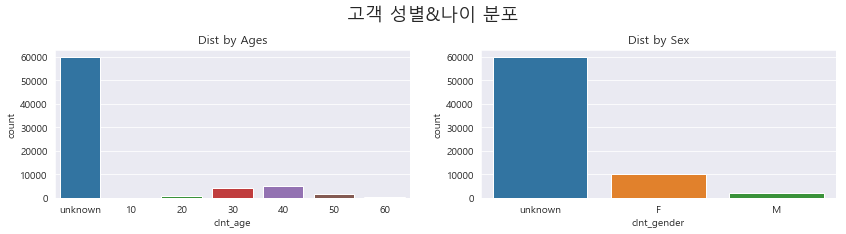

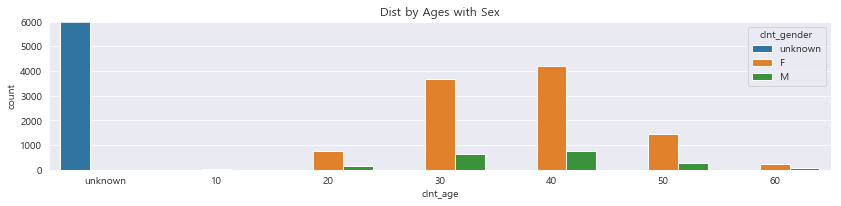

In [10]:
plt.figure(figsize=(14,6))
plt.suptitle("고객 성별&나이 분포", fontsize = 18)

plt.subplot(221)
plt.title("Dist by Ages", fontsize= 12)
sns.countplot(clnt_info.clnt_age, order = ["unknown","10","20","30","40","50","60"])

plt.subplot(222)
plt.title("Dist by Sex", fontsize= 12)
sns.countplot(clnt_info.clnt_gender)

plt.figure(figsize = (14, 6))
plt.subplot(212)
plt.title("Dist by Ages with Sex", fontsize= 12)
sns.countplot(clnt_info.clnt_age, hue=clnt_info.clnt_gender, order = ["unknown","10","20","30","40","50","60"])
plt.ylim(0,6000)

### 요일, 시간대별 주사용고객층, 접속경로 및 접속기기 파악

#### 요일별,시간별 주사용 고객층 - 접속기록 ( Not 구매기록 )

In [3]:
tmp_df_121 = online_df.groupby(["clnt_id","month","day","weekday","hour"]).size().reset_index()

In [4]:
tmp_df_121.rename(columns={0 : "counts"}, inplace = True)

Text(0.5, 1.0, '요일별 총 접속수')

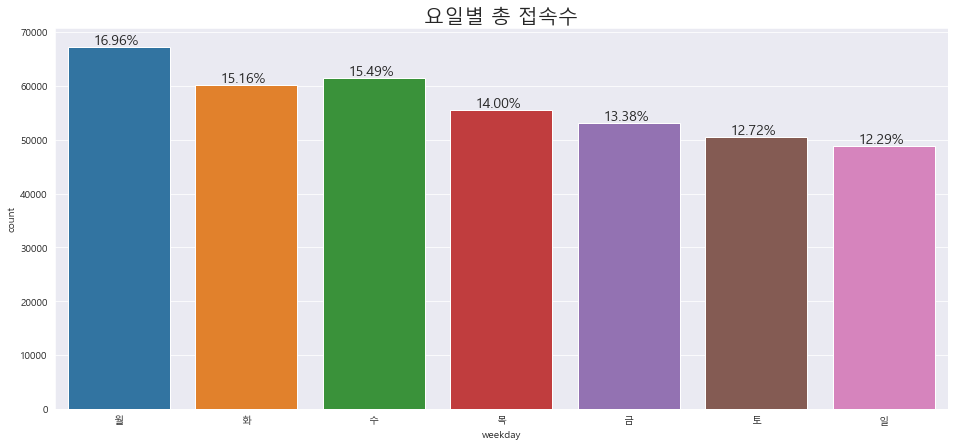

In [5]:
fig, ax = plt.subplots(figsize=(16,7))
sns.countplot(tmp_df_121.weekday)
ax.set_xticklabels(["월","화","수","목","금","토","일"])

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/4, height+500,
          "{0:.2f}%".format(height/tmp_df_121.shape[0] * 100), fontsize = 14)
    
ax.set_title("요일별 총 접속수", fontsize=20)

In [6]:
# tmp_df_121.groupby("hour").size().reset_index()

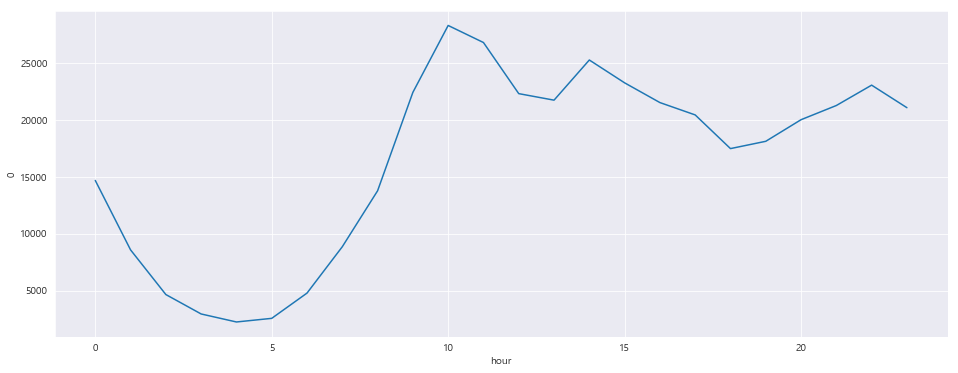

In [7]:
plt.figure(figsize = (16,6))
sns.lineplot(x = tmp_df_121.groupby("hour").size().reset_index().hour, y= tmp_df_121.groupby("hour").size().reset_index()[0])

#### 요일 + 시간 별 접속기록

In [8]:
tmp_df1211 = online_df.groupby(["clnt_id","month","day","hour","weekday"]).size().reset_index()

In [9]:
tmp_df1211.head()

,clnt_id,month,day,hour,weekday,0
0,1,9,11,16,2,3
1,1,9,22,14,6,7
2,2,7,28,23,6,42
3,2,7,29,0,0,1
4,2,7,29,7,0,6


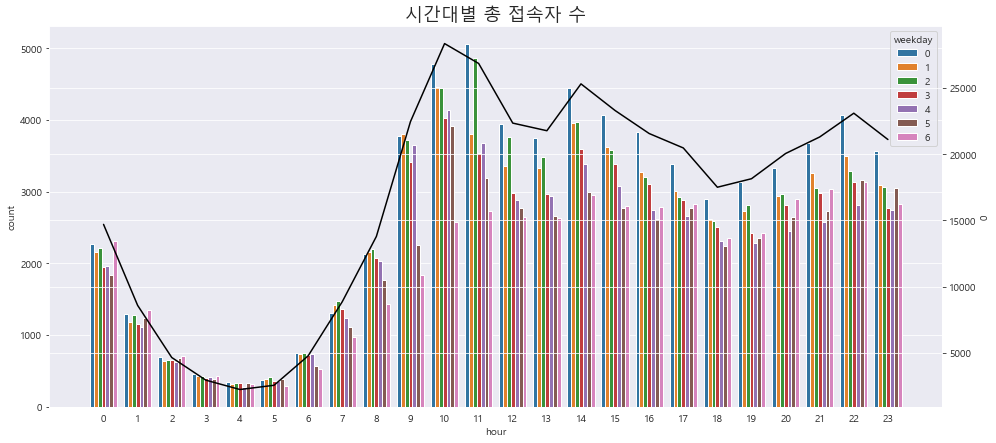

In [14]:
fig, ax = plt.subplots(figsize=(16,7))
sns.countplot(tmp_df1211.hour, hue = tmp_df1211.weekday)
#ax.set_xticklabels(["월","화","수","목","금","토","일"])

"""for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/4, height+500,
          "{0:.2f}%".format(height/tmp_df_121.shape[0] * 100), fontsize = 14)"""
    
ax.set_title("시간대별 총 접속자 수", fontsize=18)

g = ax.twinx()
g = sns.lineplot(x = tmp_df1211.groupby("hour").size().reset_index().hour, y= tmp_df1211.groupby("hour").size().reset_index()[0],
                color = 'black')

* 오전 시간대에 접속자가 가장 많음
* 점심시간 이후 잠시 접속자가 늘었다가 18시 까지 감소  
  => 당일 배송이 가능한 시간대에 접속자가 많은 듯함  
  
* 18시 이후 점차 접속자 수가 늘어남

* 월,수요일에 대부분 시간대에서 접속자 수가 가장 많음
* 주말엔 다른 요일에 비해 늦은시간 (00시 ~ 02시)까지  접속자 수가 많은 편

#### 시간별 접속경로 및 접속기기 분포 

In [15]:
tmp_122 = online_df.groupby(["clnt_id","month","day","hour","weekday","dvc_ctg_nm","trfc_src"]).size().reset_index()

In [16]:
pd.crosstab(tmp_122.dvc_ctg_nm, tmp_122.trfc_src, normalize="index")

trfc_src,DIRECT,PORTAL_1,PORTAL_2,PORTAL_3,PUSH,WEBSITE,unknown
dvc_ctg_nm,,,,,,,
PC,0.308288,0.069766,0.041511,0.011636,0.000169,0.159538,0.409091
mobile_app,0.001234,0.000000,0.000000,0.000000,0.000000,0.000579,0.998187
mobile_web,0.140336,0.041351,0.006798,0.008185,0.087988,0.061770,0.653572
unknown,0.769791,0.000000,0.000000,0.000000,0.227419,0.002790,0.000000


* 모바일 앱의 경우 대부분의 접속이 접속경로를 알 수 없음
* PC의 경우 Direct로 접속하는 경우가 가장 많으나, Direct, portal, website의 구체적인 구분이 어떻게 되는지 잘 파악이 안됨

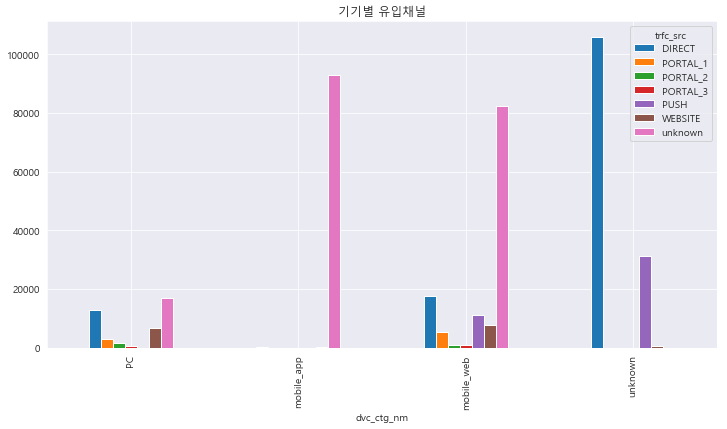

In [18]:
pd.crosstab(tmp_122.dvc_ctg_nm, tmp_122.trfc_src).plot(kind = 'bar',
                                                     figsize = (12, 6),
                                                      title = "기기별 유입채널")

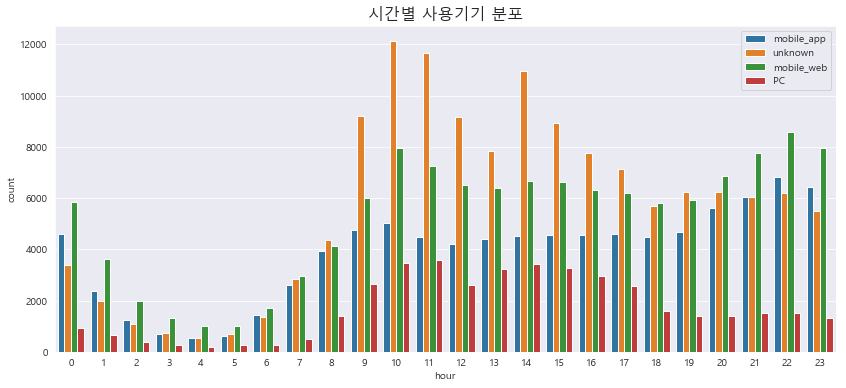

In [22]:
plt.figure(figsize= (14,6))
sns.countplot(tmp_122.hour, hue = tmp_122.dvc_ctg_nm)
plt.title("시간별 사용기기 분포", fontsize = 16)
plt.legend()

* 항상 mobile_web > mobile_app > PC 순

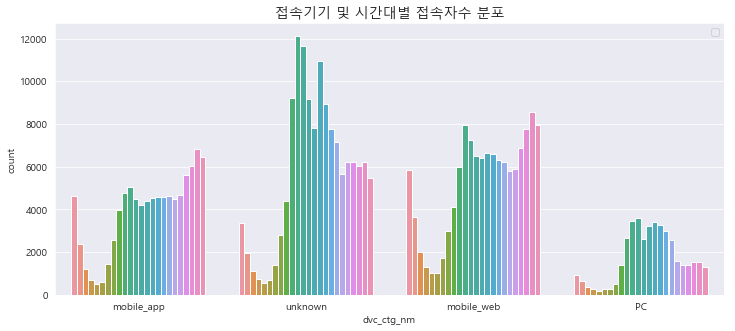

In [21]:
plt.figure(figsize= (12,5))
sns.countplot(tmp_122.dvc_ctg_nm, hue = tmp_122.hour)
plt.title("접속기기 및 시간대별 접속자수 분포", fontsize = 14)
plt.legend("")

mobile의 경우 저녁시간대에 더 많은 접속수를 보임  
pc의 경우 낮시간대에 많은 접속수. 저녁시간대엔 접속수가 크게 줄어듦

### 거래내역 많은 사람 특징 ( 15회 이상 - 상위 10% )

In [29]:
tmp_13 = online_df[online_df.trans_id!=0].groupby(["clnt_id","trans_id"]).size().reset_index()
tmp_13.rename(columns = {0 : "counts"}, inplace=True)

In [30]:
tmp_13.groupby("clnt_id").size().reset_index()[0].quantile([.1, .25, .5, .75, .8, .9, .99])
# 물건을 산 횟수 ( 장바구니 사용 결제시 1회로 count )

0.10     1.0
0.25     1.0
0.50     1.0
0.75     2.0
0.80     3.0
0.90     5.0
0.99    18.0
Name: 0, dtype: float64

In [31]:
tmp_131 = tmp_13.groupby("clnt_id").sum()[["counts"]].reset_index()
# 총 몇종류의 물품을 샀는지

In [32]:
tmp_131.counts.quantile([.1, .25, .5, .75, .8, .9, .99])

0.10     1.0
0.25     1.0
0.50     1.0
0.75     5.0
0.80     7.0
0.90    15.0
0.99    71.0
Name: counts, dtype: float64

* 50% 이상의 사람들이 구매한 이력이 한번 밖에 없음

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


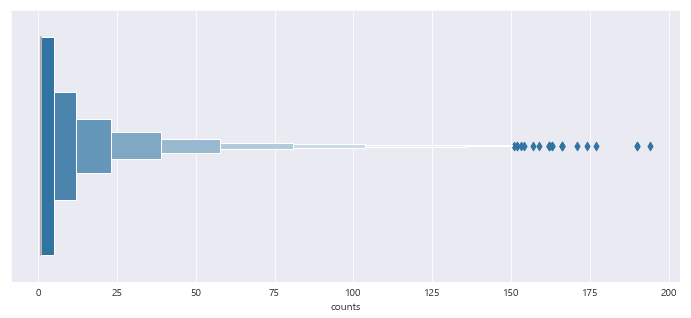

In [33]:
plt.figure(figsize = (12,5))
sns.boxenplot(tmp_131.counts)

In [34]:
# tmp_13.counts.value_counts()

In [35]:
# tmp_131.counts.value_counts()

(0, 50)

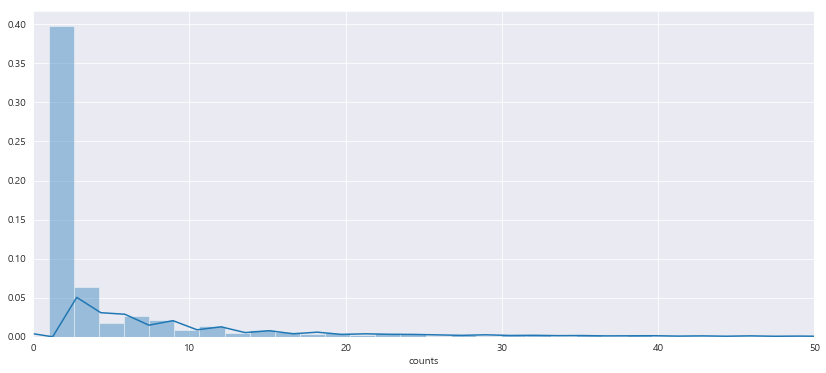

In [36]:
plt.figure(figsize = (14,6))
sns.distplot(tmp_131.counts, bins=120)
plt.xlim(0,50)

In [37]:
more_than_15_transaction = tmp_131[tmp_131.counts > 14].clnt_id.tolist()

In [38]:
online_df[online_df.clnt_id.isin(more_than_15_transaction)].groupby(["clnt_id","clnt_gender","clnt_age"]).size().reset_index().head()

,clnt_id,clnt_gender,clnt_age,0
0,9,F,40,284
1,24,F,40,196
2,49,F,50,1593
3,106,F,40,807
4,202,M,40,1829


In [39]:
vip_df = online_df[online_df.clnt_id.isin(more_than_15_transaction)].groupby(["clnt_id","clnt_gender","clnt_age"]).size().reset_index()

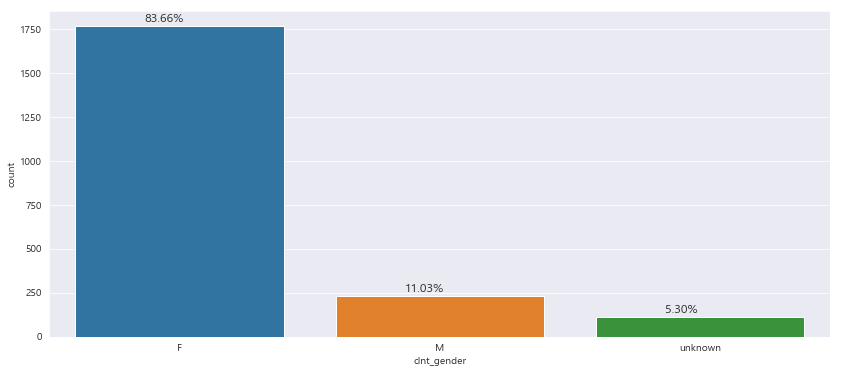

In [40]:
fig, ax = plt.subplots(figsize=(14,6))
sns.countplot(vip_df['clnt_gender'])

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/3, height + 25,
           "{0:.2f}%".format(height/2112 * 100), fontsize= 12)

* 구매가 많은 사람의 경우 unknown의 비율이 많이 줄었음
* 여성이 남성에 비해 평균적으로 더 많은 구매를 하는것 같음

'\nfor p in ax.patches:\n    height = p.get_height()\n    ax.text(p.get_x() + p.get_width()/3, height + 25,\n           "{0:.2f}%".format(height/2112 * 100), fontsize= 12)'

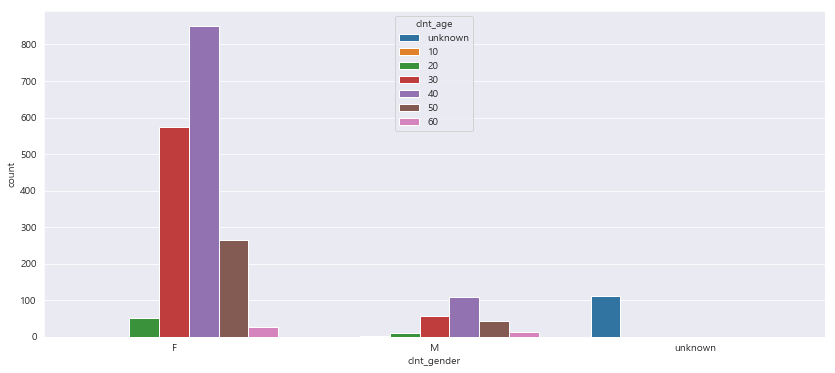

In [160]:
fig, ax = plt.subplots(figsize=(14,6))
sns.countplot(vip_df['clnt_gender'], hue = vip_df.clnt_age, hue_order=["unknown","10","20","30","40","50","60"])
"""
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/3, height + 25,
           "{0:.2f}%".format(height/2112 * 100), fontsize= 12)"""

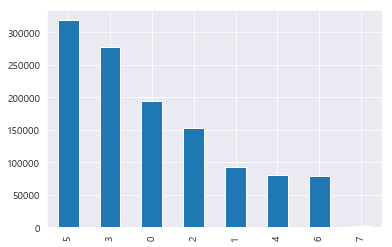

In [178]:
online_df[online_df.clnt_id.isin(more_than_15_transaction)].action_type.value_counts().plot(kind = 'bar')

#### 거래기록 한번밖에 없는 사람

In [172]:
one_trans = tmp_131[tmp_131.counts == 1].clnt_id

In [173]:
one_trans_df = online_df[online_df.clnt_id.isin(one_trans)]

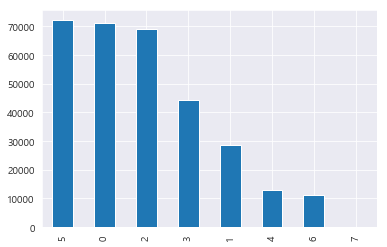

In [176]:
one_trans_df.action_type.value_counts().plot(kind = 'bar')

* 결제 시도가 다른 action type들에 비해 더 많은 이유가 무엇인지?? ( 위의 case도 동일 )

'\nfor p in ax.patches:\n    height = p.get_height()\n    ax.text(p.get_x() + p.get_width()/3, height + 25,\n           "{0:.2f}%".format(height/2112 * 100), fontsize= 12)'

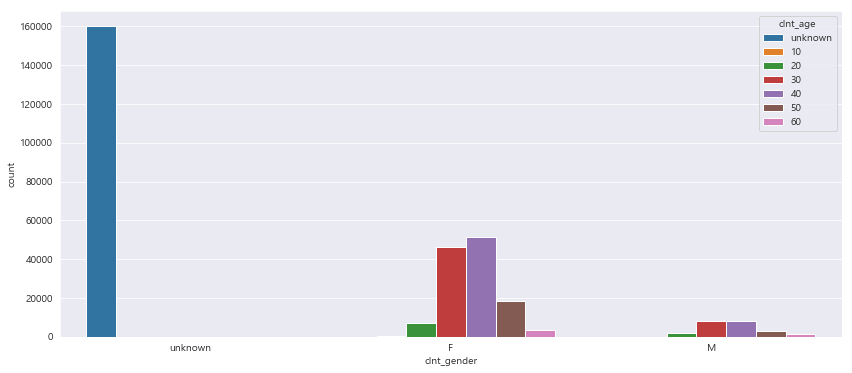

In [198]:
fig, ax = plt.subplots(figsize=(14,6))
sns.countplot(one_trans_df['clnt_gender'], hue = one_trans_df.clnt_age, hue_order=["unknown","10","20","30","40","50","60"])
"""
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/3, height + 25,
           "{0:.2f}%".format(height/2112 * 100), fontsize= 12)"""

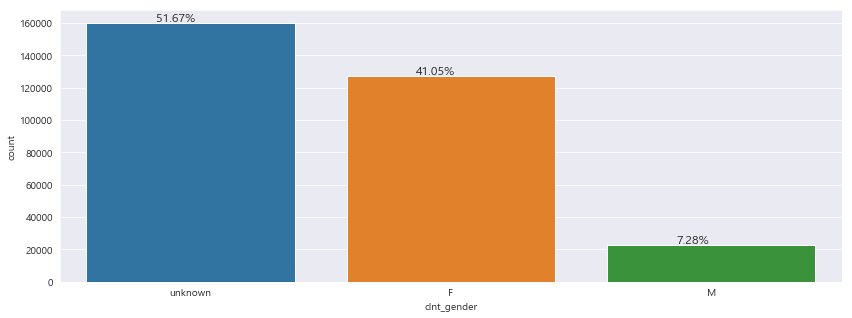

In [197]:
fig, ax = plt.subplots(figsize=(14,5))
sns.countplot(one_trans_df['clnt_gender'])

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/3, height + 1000,
           "{0:.2f}%".format(height/one_trans_df.shape[0] * 100), fontsize= 12)

#### 잠재고객 & 기존고객 성별 및 나이대 분포

In [5]:
buying_clnt = online_df[online_df.action_type==6].clnt_id.unique()

In [6]:
latent_info = online_df[~online_df.clnt_id.isin(buying_clnt)].drop_duplicates(["clnt_id"])[["clnt_id","clnt_gender","clnt_age"]]

In [7]:
pd.crosstab(latent_info.clnt_gender, latent_info.clnt_age, normalize=True)

clnt_age,20,30,40,50,60,unknown
clnt_gender,,,,,,
F,0.000175,0.000388,0.000659,0.000349,0.000058,0.000000
M,0.000039,0.000097,0.000039,0.000019,0.000019,0.000000
unknown,0.000000,0.000000,0.000000,0.000000,0.000000,0.998158


In [8]:
# 잠재 고객의 99.8%의 성별과 나이가 UNKNOWN

In [9]:
base_user_info = online_df[online_df.clnt_id.isin(buying_clnt)].drop_duplicates(["clnt_id"])[["clnt_id","clnt_gender","clnt_age"]]

In [10]:
pd.crosstab(base_user_info.clnt_gender, base_user_info.clnt_age, normalize=True)

clnt_age,10,20,30,40,50,60,unknown
clnt_gender,,,,,,,
F,0.001632,0.036145,0.175683,0.199971,0.068017,0.011424,0.000000
M,0.000576,0.007680,0.029856,0.035809,0.012384,0.004032,0.000000
unknown,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.416791


In [11]:
pd.crosstab(base_user_info.clnt_gender, base_user_info.clnt_age, normalize=True).sum(axis=1)

clnt_gender
F          0.492872
M          0.090337
unknown    0.416791
dtype: float64

In [ ]:
# 기존 고객의 40%는 고객정보가 unknown, 전체의 약 49% 이상이 여성소비자, 전체의 약 9%정도만이 남성소비자였음
# 고객정보가 존재하는 기존 고객의 경우 40대 여성(약 20%)이 가장 많았고 30대 여성(약 18%), 50대 여성(약 7%) 순

### 거래량

In [74]:
# tmp_114 = online_df[online_df.action_type==6].groupby(["month", "day"]).size().reset_index()

In [75]:
tmp_114 = online_df[(online_df.action_type==6) & (online_df.trans_id!=0)].groupby(["month", "day", "trans_id"]).size().reset_index().groupby(["month","day"]).size().reset_index()

In [65]:
# online_df[["month","day","weekday"]].drop_duplicates(keep = "first").reset_index(drop = True)

In [76]:
tmp_114

,month,day,0
0,7,1,581
1,7,2,595
2,7,3,695
3,7,4,616
4,7,5,516
5,7,6,553
6,7,7,467
7,7,8,835
8,7,9,592
9,7,10,632


In [77]:
tmp_114 = tmp_114.merge(online_df[["month","day","weekday"]].drop_duplicates(keep = "first").reset_index(drop = True), how = "left", on = ["month", "day"])

In [78]:
tmp_114['is_holiday'] = np.where(tmp_114.weekday < 5, 0, 1)

In [81]:
tmp_114.head(14)

,month,day,0,weekday,is_holiday
0,7,1,581,0,0
1,7,2,595,1,0
2,7,3,695,2,0
3,7,4,616,3,0
4,7,5,516,4,0
5,7,6,553,5,1
6,7,7,467,6,1
7,7,8,835,0,0
8,7,9,592,1,0
9,7,10,632,2,0


In [1]:
"""plt.figure(figsize=(16,6))
sns.lineplot(x=tmp_114.index, y=tmp_114[0], color = 'k')
for i in range(14):
    plt.vlines(i*7, 0, 850, colors="orange")"""

'plt.figure(figsize=(16,6))\nsns.lineplot(x=tmp_114.index, y=tmp_114[0], color = \'k\')\nfor i in range(14):\n    plt.vlines(i*7, 0, 850, colors="orange")'

## 2

### 재구매까지 걸리는 시간

In [5]:
tmp_2 = online_df[online_df.action_type == 6].drop_duplicates(["clnt_id","time"], keep = "first")

In [12]:
tmp_2.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,min,trans_seq,pd_c,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm1,clac_nm2,clac_nm3
46,2,1,37,6,A03,20190728,23:47,791905,62037.0,NaN,...,47,-1.0,-1,-1.0,-1.0,F,30,NaN,NaN,NaN
145,2,8,68,6,A03,20190731,21:25,3251794,64691.0,NaN,...,25,5.0,92,1800.0,1.0,F,30,Beverages,Coffee Drinks,Coffee Drinks
171,2,10,16,6,A03,20190801,22:00,306944,65505.0,NaN,...,0,1.0,92,9000.0,5.0,F,30,Beverages,Coffee Drinks,Coffee Drinks
251,2,19,17,6,A03,20190830,22:00,2227390,88495.0,NaN,...,0,2.0,1395,2850.0,1.0,F,30,Substitute Foods,Instant Noodles,Ramens
276,4,1,2,6,A01,20190826,10:38,402600,85046.0,NaN,...,38,-1.0,-1,-1.0,-1.0,unknown,unknown,NaN,NaN,NaN


In [15]:
(tmp_2[["clnt_id"]] - tmp_2[["clnt_id"]].shift()).fillna(0)[(tmp_2[["clnt_id"]] - tmp_2[["clnt_id"]].shift()).fillna(0).clnt_id != 0].index

Int64Index([    276,     433,     628,     719,     741,     742,     759,
                767,     931,    1076,
            ...
            3269140, 3269167, 3269335, 3269431, 3269558, 3269614, 3269621,
            3269633, 3269725, 3269783],
           dtype='int64', length=20832)

In [19]:
tmp_2.time = pd.to_datetime(tmp_2.time)

In [40]:
timedeltas = (tmp_2[["time"]] - tmp_2[["time"]].shift()).fillna(0)

c:\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  """Entry point for launching an IPython kernel.


In [53]:
tmp_21 = pd.concat([tmp_2[["clnt_id","time"]], timedeltas], axis=1)

In [54]:
tmp_21.columns = ["clnt_id", "time", "timedelta"]

In [56]:
tmp_21['elapsed_time'] = tmp_21.timedelta.apply(lambda x : x.days)

In [58]:
tmp_21.loc[tmp_21.elapsed_time < 0, "elapsed_time"] = 0 

In [142]:
tmp_2

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,min,trans_seq,pd_c,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm1,clac_nm2,clac_nm3
46,2,1,37,6,A03,20190728,23:47,791905,62037.0,NaN,...,47,-1.0,-1,-1.0,-1.0,F,30,NaN,NaN,NaN
145,2,8,68,6,A03,20190731,21:25,3251794,64691.0,NaN,...,25,5.0,92,1800.0,1.0,F,30,Beverages,Coffee Drinks,Coffee Drinks
171,2,10,16,6,A03,20190801,22:00,306944,65505.0,NaN,...,0,1.0,92,9000.0,5.0,F,30,Beverages,Coffee Drinks,Coffee Drinks
251,2,19,17,6,A03,20190830,22:00,2227390,88495.0,NaN,...,0,2.0,1395,2850.0,1.0,F,30,Substitute Foods,Instant Noodles,Ramens
276,4,1,2,6,A01,20190826,10:38,402600,85046.0,NaN,...,38,-1.0,-1,-1.0,-1.0,unknown,unknown,NaN,NaN,NaN
433,9,6,27,6,A03,20190708,13:48,1853427,45242.0,NaN,...,48,8.0,515,6990.0,1.0,F,40,Frozen Foods,Frozen Instant Foods,Frozen Dumplings
565,9,26,26,6,A03,20190904,21:36,1144847,92448.0,NaN,...,36,6.0,348,2490.0,1.0,F,40,Dairy Products,Milk,Functional Milk
628,12,1,2,6,A01,20190718,10:10,133918,54099.0,NaN,...,10,-1.0,-1,-1.0,-1.0,F,40,NaN,NaN,NaN
719,17,3,63,6,A03,20190731,01:07,3976957,64325.0,NaN,...,7,-1.0,-1,-1.0,-1.0,unknown,unknown,NaN,NaN,NaN
741,19,1,1,6,A01,20190810,16:33,1377191,72882.0,NaN,...,33,-1.0,-1,-1.0,-1.0,unknown,unknown,NaN,NaN,NaN


In [61]:
tmp_21

,clnt_id,time,timedelta,elapsed_time
46,2,2019-07-28 23:47:00,0 days 00:00:00,0
145,2,2019-07-31 21:25:00,2 days 21:38:00,2
171,2,2019-08-01 22:00:00,1 days 00:35:00,1
251,2,2019-08-30 22:00:00,29 days 00:00:00,29
276,4,2019-08-26 10:38:00,-5 days +12:38:00,0
433,9,2019-07-08 13:48:00,-49 days +03:10:00,0
565,9,2019-09-04 21:36:00,58 days 07:48:00,58
628,12,2019-07-18 10:10:00,-49 days +12:34:00,0
719,17,2019-07-31 01:07:00,12 days 14:57:00,12
741,19,2019-08-10 16:33:00,10 days 15:26:00,10


In [64]:
tmp_21 = tmp_21.groupby("clnt_id").aggregate(["sum","count"])[["elapsed_time"]]

In [146]:
mean_period = (tmp_21.elapsed_time["sum"] / (tmp_21.elapsed_time["count"]-1)).fillna(99).replace(np.inf, 99)

In [306]:
mean_period_2 = np.round((tmp_21.elapsed_time["sum"] / (tmp_21.elapsed_time["count"]-1)).fillna(99).replace(np.inf, 99))

In [313]:
tmp_210 = mean_period_2.reset_index()[0].value_counts().reset_index()

In [2]:
"""plt.figure(figsize = (30,6))
sns.barplot(x = tmp_210["index"].iloc[:60], y=tmp_210[0].iloc[:60])"""

'plt.figure(figsize = (30,6))\nsns.barplot(x = tmp_210["index"].iloc[:60], y=tmp_210[0].iloc[:60])'

In [316]:
tmp_210

,index,0
0,99.0,11794
1,0.0,1226
2,6.0,404
3,8.0,370
4,10.0,362
5,4.0,347
6,7.0,333
7,9.0,328
8,5.0,302
9,12.0,301


In [304]:
mean_period.reset_index()

,clnt_id,0
0,2,10.666667
1,4,99.000000
2,9,58.000000
3,12,99.000000
4,17,99.000000
5,19,99.000000
6,20,99.000000
7,22,99.000000
8,23,12.833333
9,24,47.000000


In [3]:
"""plt.figure(figsize = (12,10))
sns.scatterplot(x = tmp_21.elapsed_time["count"], y=mean_period.reset_index()[0], size = 1)"""

'plt.figure(figsize = (12,10))\nsns.scatterplot(x = tmp_21.elapsed_time["count"], y=mean_period.reset_index()[0], size = 1)'

* x축 : 거래횟수 , y축 : 다음거래까지의 평균기간

### 접속경로 및 접속기기 별 평균 접속기간

#### 기기별 

In [160]:
online_df.head()
# tot_sess_hr_v => sess_id가 같으면 시간 같음

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,min,trans_seq,pd_c,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm1,clac_nm2,clac_nm3
0,1,1,1,0,A01,20190911,16:14,11880,NaN,과일선물세트,...,14,-1.0,-1,-1.0,-1.0,unknown,unknown,NaN,NaN,NaN
1,1,1,2,0,A01,20190911,16:15,22432,NaN,과일선물세트 백화점,...,15,-1.0,-1,-1.0,-1.0,unknown,unknown,NaN,NaN,NaN
2,1,1,3,0,A01,20190911,16:15,36140,NaN,과일바구니,...,15,-1.0,-1,-1.0,-1.0,unknown,unknown,NaN,NaN,NaN
3,1,2,1,0,A01,20190922,14:09,41584,NaN,초등가을잠바,...,9,-1.0,-1,-1.0,-1.0,unknown,unknown,NaN,NaN,NaN
4,1,2,2,0,A01,20190922,14:10,56113,NaN,초등가을점퍼,...,10,-1.0,-1,-1.0,-1.0,unknown,unknown,NaN,NaN,NaN


In [22]:
tmp_22 = online_df.drop_duplicates(["clnt_id","sess_id"], keep = "first")

Text(0.5, 1.0, '기기별 총 세션접속시간 분포')

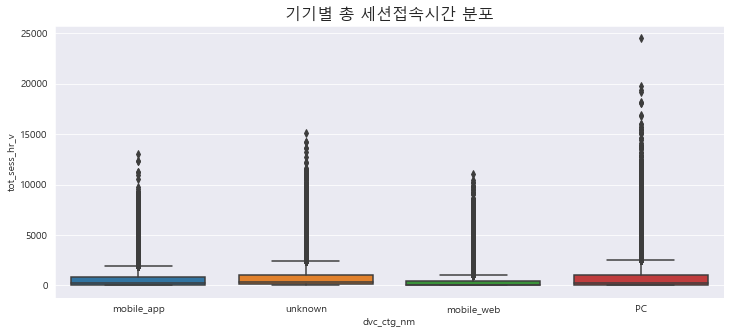

In [39]:
plt.figure(figsize = (12,5))
sns.boxplot( y= tmp_22.tot_sess_hr_v, x=tmp_22.dvc_ctg_nm)
plt.title("기기별 총 세션접속시간 분포", fontsize = 16)

Text(0.5, 1.0, '기기별 총 세션접속시간 분포')

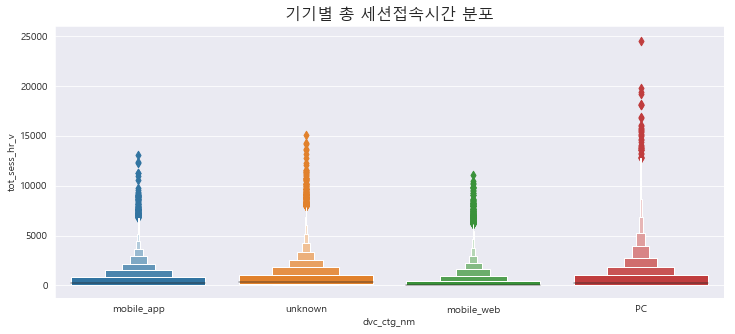

In [44]:
plt.figure(figsize = (12,5))
sns.boxenplot( y= tmp_22.tot_sess_hr_v, x=tmp_22.dvc_ctg_nm, label = ["mobile_app", "mobile_web", "PC"])
plt.title("기기별 총 세션접속시간 분포", fontsize = 16)

In [27]:
tmp_22["mean_stay_time"] = np.round(tmp_22.tot_sess_hr_v / tmp_22.tot_pag_view_ct)

c:\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Text(0.5, 1.0, '기기별 평균 세션접속시간 분포')

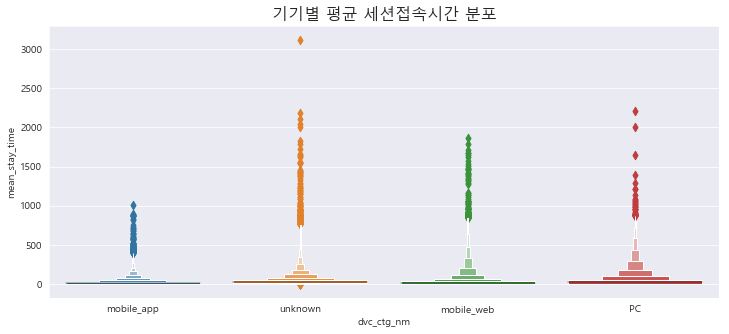

In [28]:
plt.figure(figsize = (12,5))
sns.boxenplot( y= tmp_22.mean_stay_time, x=tmp_22.dvc_ctg_nm, label = ["mobile_app", "mobile_web", "PC"])
plt.title("기기별 평균 세션접속시간 분포", fontsize = 16)

Text(0.5, 0.98, '기기별 세션접속시간 분포')

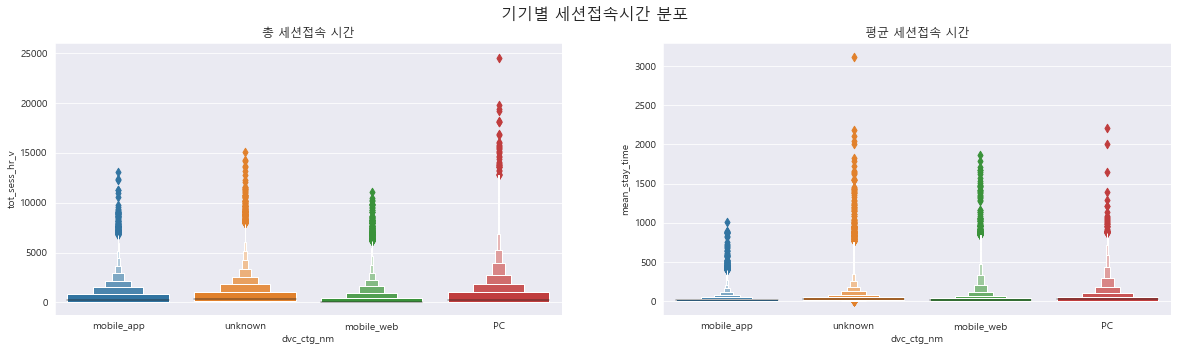

In [37]:
fig, ax = plt.subplots(ncols= 2, figsize = (20,5))
sns.boxenplot( y= tmp_22.tot_sess_hr_v, x=tmp_22.dvc_ctg_nm, ax = ax[0])
sns.boxenplot( y= tmp_22.mean_stay_time, x=tmp_22.dvc_ctg_nm, ax = ax[1])
ax[0].set_title("총 세션접속 시간",fontsize=12)
ax[1].set_title("평균 세션접속 시간", fontsize=12)

plt.suptitle("기기별 세션접속시간 분포", fontsize=16)

(0, 300)

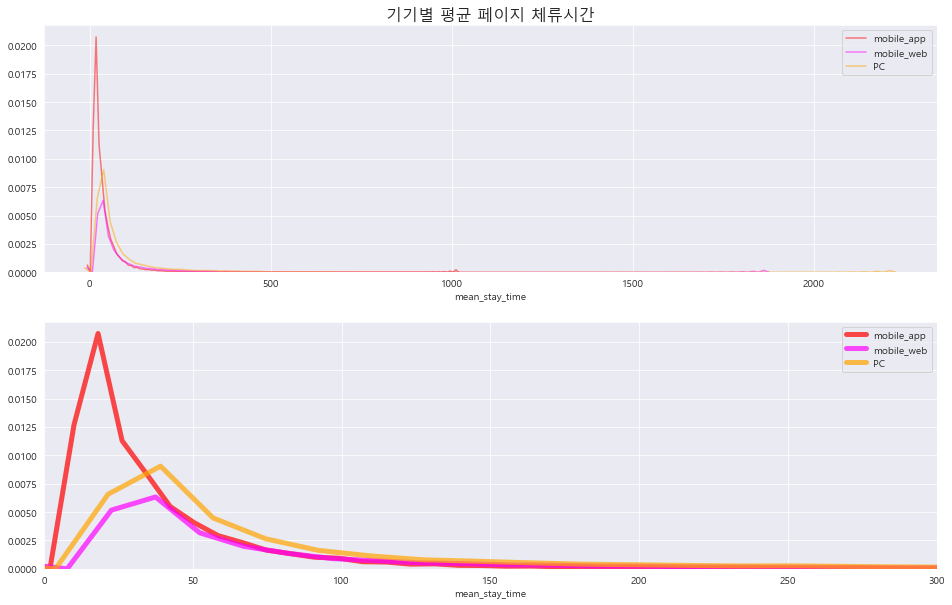

In [91]:
fig, ax = plt.subplots(2,figsize = (16,10))

sns.distplot(tmp_22[tmp_22.dvc_ctg_nm == "mobile_app"].mean_stay_time, hist = False,
             kde_kws = {"alpha" : 0.5},color='red', label = "mobile_app", ax = ax[0])
sns.distplot(tmp_22[tmp_22.dvc_ctg_nm == "mobile_web"].mean_stay_time, hist = False,
             kde_kws = {"alpha" : 0.5}, color='magenta', label = "mobile_web", ax = ax[0])
sns.distplot(tmp_22[tmp_22.dvc_ctg_nm == "PC"].mean_stay_time, hist = False,
             kde_kws = {"alpha" : 0.5}, color='orange', label = "PC", ax = ax[0])
ax[0].set_title("기기별 평균 페이지 체류시간", fontsize = 16)

sns.distplot(tmp_22[tmp_22.dvc_ctg_nm == "mobile_app"].mean_stay_time, hist = False,
             kde_kws = {"alpha" : 0.7, "linewidth" : 5},color='red', label = "mobile_app", ax = ax[1])
sns.distplot(tmp_22[tmp_22.dvc_ctg_nm == "mobile_web"].mean_stay_time, hist = False,
             kde_kws = {"alpha" : 0.7, "linewidth" : 5}, color='magenta', label = "mobile_web", ax = ax[1])
sns.distplot(tmp_22[tmp_22.dvc_ctg_nm == "PC"].mean_stay_time, hist = False,
             kde_kws = {"alpha" : 0.7, "linewidth" : 5}, color='orange', label = "PC", ax = ax[1])
ax[1].set_xlim(0,300)

(0, 300)

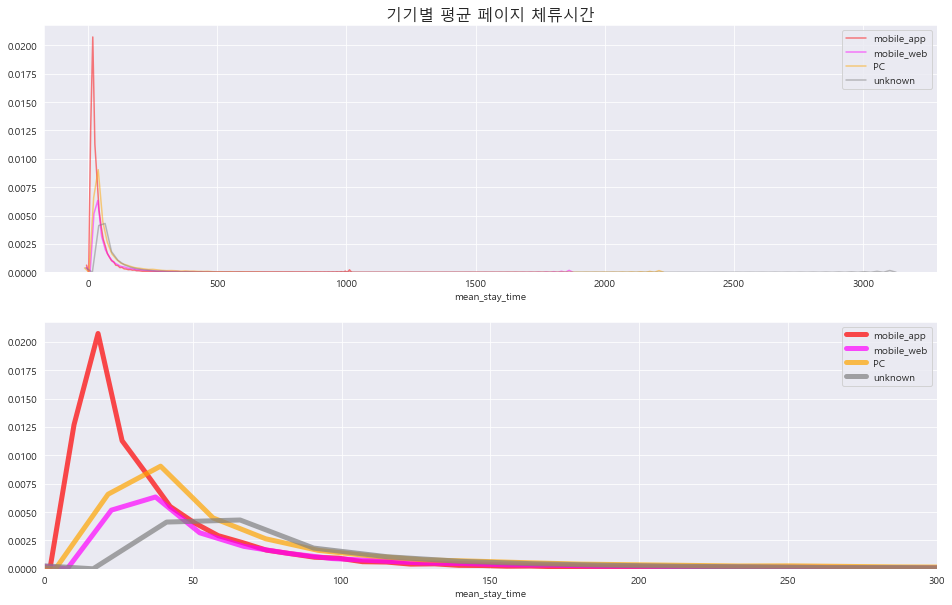

In [97]:
fig, ax = plt.subplots(2,figsize = (16,10))

sns.distplot(tmp_22[tmp_22.dvc_ctg_nm == "mobile_app"].mean_stay_time, hist = False,
             kde_kws = {"alpha" : 0.5},color='red', label = "mobile_app", ax = ax[0])
sns.distplot(tmp_22[tmp_22.dvc_ctg_nm == "mobile_web"].mean_stay_time, hist = False,
             kde_kws = {"alpha" : 0.5}, color='magenta', label = "mobile_web", ax = ax[0])
sns.distplot(tmp_22[tmp_22.dvc_ctg_nm == "PC"].mean_stay_time, hist = False,
             kde_kws = {"alpha" : 0.5}, color='orange', label = "PC", ax = ax[0])
sns.distplot(tmp_22[tmp_22.dvc_ctg_nm == "unknown"].mean_stay_time, hist = False,
             kde_kws = {"alpha" : 0.5}, color='grey', label = "unknown", ax = ax[0])
ax[0].set_title("기기별 평균 페이지 체류시간", fontsize = 16)

sns.distplot(tmp_22[tmp_22.dvc_ctg_nm == "mobile_app"].mean_stay_time, hist = False,
             kde_kws = {"alpha" : 0.7, "linewidth" : 5},color='red', label = "mobile_app", ax = ax[1])
sns.distplot(tmp_22[tmp_22.dvc_ctg_nm == "mobile_web"].mean_stay_time, hist = False,
             kde_kws = {"alpha" : 0.7, "linewidth" : 5}, color='magenta', label = "mobile_web", ax = ax[1])
sns.distplot(tmp_22[tmp_22.dvc_ctg_nm == "PC"].mean_stay_time, hist = False,
             kde_kws = {"alpha" : 0.7, "linewidth" : 5}, color='orange', label = "PC", ax = ax[1])
sns.distplot(tmp_22[tmp_22.dvc_ctg_nm == "unknown"].mean_stay_time, hist = False,
             kde_kws = {"alpha" : 0.7, "linewidth" : 5}, color='grey', label = "unknown", ax = ax[1])
ax[1].set_xlim(0,300)

Text(0.5, 1.0, '기기별 총 페이지 수 분포')

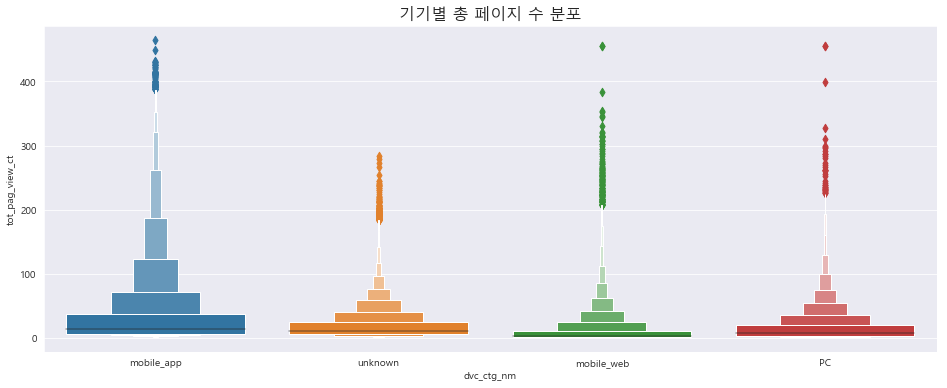

In [98]:
plt.figure(figsize = (16,6))
sns.boxenplot(x=tmp_22.dvc_ctg_nm, y=tmp_22.tot_pag_view_ct)
plt.title("기기별 총 페이지 수 분포", fontsize = 16)

Text(0.5, 1.0, '기기별 총 페이지 수 분포')

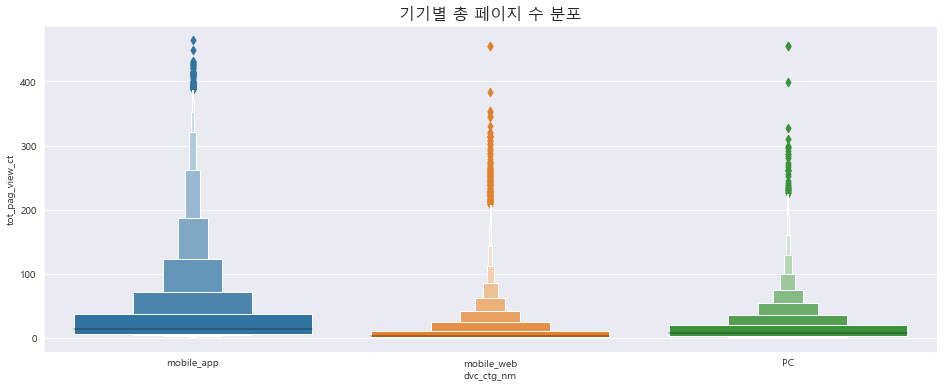

In [205]:
plt.figure(figsize = (16,6))
sns.boxenplot(x=tmp_22.dvc_ctg_nm, y=tmp_22.tot_pag_view_ct)
plt.title("기기별 총 페이지 수 분포", fontsize = 16)

#### 접속 경로별 

In [6]:
tmp_22.columns

Index(['clnt_id', 'sess_id', 'hit_seq', 'action_type', 'biz_unit', 'sess_dt',
       'hit_tm', 'hit_pss_tm', 'trans_id', 'sech_kwd', 'tot_pag_view_ct',
       'tot_sess_hr_v', 'trfc_src', 'dvc_ctg_nm', 'time', 'year', 'month',
       'day', 'weekday', 'hour', 'min', 'trans_seq', 'pd_c', 'buy_am',
       'buy_ct', 'clnt_gender', 'clnt_age', 'clac_nm1', 'clac_nm2',
       'clac_nm3'],
      dtype='object')

Text(0.5, 1.0, '기기별 평균 세션접속시간 분포')

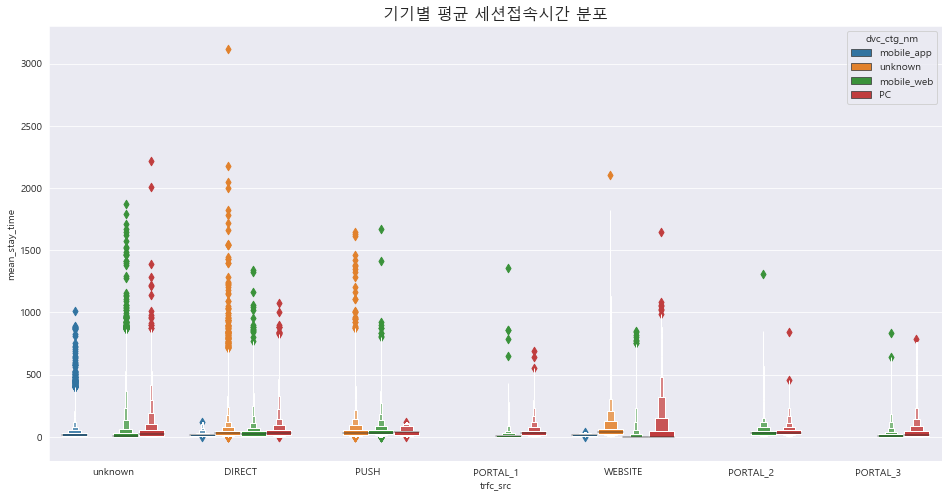

In [99]:
plt.figure(figsize = (16,8))
sns.boxenplot( y= tmp_22.mean_stay_time, x=tmp_22.trfc_src, hue=tmp_22.dvc_ctg_nm)
plt.title("기기별 평균 세션접속시간 분포", fontsize = 16)

Text(0.5, 1.0, '기기별 평균 세션접속시간 분포')

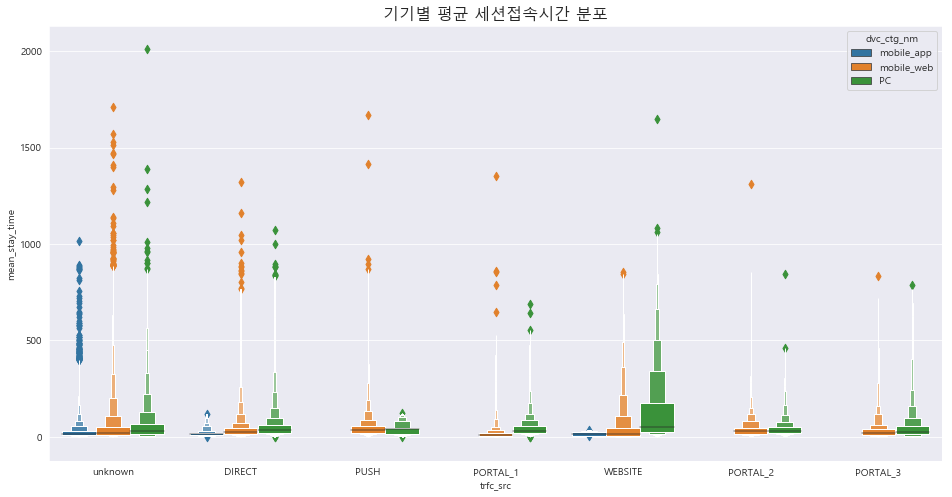

In [218]:
plt.figure(figsize = (16,8))
sns.boxenplot( y= tmp_22.mean_stay_time, x=tmp_22.trfc_src, hue=tmp_22.dvc_ctg_nm)
plt.title("기기별 평균 세션접속시간 분포", fontsize = 16)

In [4]:
"""plt.figure(figsize = (16,8))
sns.boxenplot( y= tmp_22.tot_sess_hr_v, x=tmp_22.trfc_src, hue=tmp_22.dvc_ctg_nm)
plt.title("기기별 총 세션접속시간 분포", fontsize = 16)"""

'plt.figure(figsize = (16,8))\nsns.boxenplot( y= tmp_22.tot_sess_hr_v, x=tmp_22.trfc_src, hue=tmp_22.dvc_ctg_nm)\nplt.title("기기별 총 세션접속시간 분포", fontsize = 16)'

In [5]:
""""""plt.figure(figsize = (16,8))
sns.boxenplot( y= tmp_22.tot_sess_hr_v, x=tmp_22.trfc_src, hue=tmp_22.dvc_ctg_nm)
plt.title("기기별 총 세션접속시간 분포", fontsize = 16)""""""

SyntaxError: invalid syntax (<ipython-input-5-51f0441e9d72>, line 1)

In [21]:
tmp_22.groupby(["dvc_ctg_nm","trfc_src"]).quantile([.1, .25, .5, .9])["tot_pag_view_ct"].reset_index().sort_values(["dvc_ctg_nm", "tot_pag_view_ct"], ascending = False)

,dvc_ctg_nm,trfc_src,level_2,tot_pag_view_ct
59,mobile_web,PUSH,0.90,56.0
51,mobile_web,PORTAL_2,0.90,45.0
43,mobile_web,DIRECT,0.90,42.0
47,mobile_web,PORTAL_1,0.90,24.0
67,mobile_web,unknown,0.90,24.0
55,mobile_web,PORTAL_3,0.90,21.0
58,mobile_web,PUSH,0.50,15.0
50,mobile_web,PORTAL_2,0.50,10.0
42,mobile_web,DIRECT,0.50,9.0
63,mobile_web,WEBSITE,0.90,8.0


In [19]:
tmp_22.groupby(["dvc_ctg_nm","trfc_src"]).mean()["tot_pag_view_ct"].reset_index().sort_values(["dvc_ctg_nm", "tot_pag_view_ct"], ascending = False)

,dvc_ctg_nm,trfc_src,tot_pag_view_ct
14,mobile_web,PUSH,23.796875
12,mobile_web,PORTAL_2,19.406250
10,mobile_web,DIRECT,17.031250
11,mobile_web,PORTAL_1,10.101562
16,mobile_web,unknown,9.414062
13,mobile_web,PORTAL_3,7.886719
15,mobile_web,WEBSITE,4.011719
8,mobile_app,WEBSITE,73.250000
7,mobile_app,DIRECT,59.593750
9,mobile_app,unknown,34.687500


In [6]:
"""plt.figure(figsize = (16,6))
sns.boxenplot(x=tmp_22.trfc_src, y=tmp_22.tot_pag_view_ct, hue= tmp_22.dvc_ctg_nm)
plt.title("기기별 총 페이지 수 분포", fontsize = 16)"""

'plt.figure(figsize = (16,6))\nsns.boxenplot(x=tmp_22.trfc_src, y=tmp_22.tot_pag_view_ct, hue= tmp_22.dvc_ctg_nm)\nplt.title("기기별 총 페이지 수 분포", fontsize = 16)'

In [7]:
"""plt.figure(figsize = (16,6))
sns.boxenplot(x=tmp_22.trfc_src, y=tmp_22.tot_pag_view_ct, hue= tmp_22.dvc_ctg_nm)
plt.title("기기별 총 페이지 수 분포", fontsize = 16)"""

'plt.figure(figsize = (16,6))\nsns.boxenplot(x=tmp_22.trfc_src, y=tmp_22.tot_pag_view_ct, hue= tmp_22.dvc_ctg_nm)\nplt.title("기기별 총 페이지 수 분포", fontsize = 16)'

### 월별 카테고리 소비량 

In [224]:
online_df[~online_df.clac_nm1.isnull()].action_type.value_counts()

6    86653
Name: action_type, dtype: int64

In [226]:
tmp_23 = online_df[~online_df.clac_nm1.isnull()]

In [235]:
#index => month, columns => clac_nm1, count 
tmp_231 = tmp_23.groupby(["clnt_id", "month", "clac_nm1"]).size().reset_index().groupby(["month","clac_nm1"]).sum().reset_index().drop("clnt_id", axis=1)

In [238]:
tmp_231_sub7 = tmp_231.sort_values(by = ["month",0], ascending = False)[tmp_231.sort_values(by = ["month",0], ascending = False).month == 7]
tmp_231_sub8 = tmp_231.sort_values(by = ["month",0], ascending = False)[tmp_231.sort_values(by = ["month",0], ascending = False).month == 8]
tmp_231_sub9 = tmp_231.sort_values(by = ["month",0], ascending = False)[tmp_231.sort_values(by = ["month",0], ascending = False).month == 9]

In [247]:
tmp_231_sub7.reset_index(drop = True, inplace=True)
tmp_231_sub8.reset_index(drop = True, inplace=True)
tmp_231_sub9.reset_index(drop = True, inplace=True)

In [263]:
tmp_231_sub7.columns = ["month", "clac_nm1", 7]
tmp_231_sub8.columns = ["month", "clac_nm1", 8]
tmp_231_sub9.columns = ["month", "clac_nm1", 9]

In [274]:
tmp_231_merge = tmp_231_sub7.iloc[:,1:].merge(tmp_231_sub8.iloc[:,1:],how = "left", on = "clac_nm1").merge(tmp_231_sub9.iloc[:,1:],how = "left", on = "clac_nm1").fillna(0)

In [290]:
tmp_231_merge

,clac_nm1,7,8,9
0,Vegetables,3919,3721,3603.0
1,Meats,2944,2791,2368.0
2,Substitute Foods,2839,2744,2510.0
3,Chilled Foods,2751,2382,2352.0
4,Snack Foods,2664,2731,2199.0
5,Dairy Products,2566,2570,2360.0
6,Frozen Foods,2042,1989,1940.0
7,Fruits,1902,1927,1540.0
8,Beverages,1802,1737,1802.0
9,Spices / Seasonings,1081,1219,1245.0


In [261]:
multi_table([tmp_231_sub7[:20][["clac_nm1"]], tmp_231_sub8[:20][["clac_nm1"]], tmp_231_sub9[:20][["clac_nm1"]]])

,clac_nm1
0,Vegetables
1,Meats
2,Substitute Foods
3,Chilled Foods
4,Snack Foods
5,Dairy Products
6,Frozen Foods
7,Fruits
8,Beverages
9,Spices / Seasonings


In [8]:
"""tmp_231_merge.T[1:].plot(figsize= (10,20))
# lstm을 통해 앞으로 1주일동안 판매될 상품수 예측 => 전 주에 비해 줄어들지 늘어날지 파악 => 추천시 가중치 부여"""

'tmp_231_merge.T[1:].plot(figsize= (10,20))\n# lstm을 통해 앞으로 1주일동안 판매될 상품수 예측 => 전 주에 비해 줄어들지 늘어날지 파악 => 추천시 가중치 부여'

In [325]:
online_df[online_df.action_type==6].clnt_id.nunique()

20833

In [326]:
online_df.clnt_id.nunique()

72399

In [334]:
online_df[online_df.action_type==0].sech_kwd.value_counts()

우유              8985
두부              5210
계란              5039
생수              4283
수박              2694
라면              2583
오이              2493
콩나물             2481
쌀               2046
식빵              2007
어묵              1887
양파              1864
과자              1847
바나나             1845
당근              1772
상추              1656
삼겹살             1630
햇반              1629
요구르트            1604
복숭아             1567
김               1521
버섯              1511
떡볶이             1381
요플레             1360
원피스             1357
김치              1339
대파              1305
만두              1300
닭               1293
치즈              1278
                ... 
sv8lt81            1
노피아 플리츠 원피스        1
종합어묵               1
록시 점프수트            1
mango 니트           1
밀기류                1
갤럭시s10 카카오         1
T194MOP285W        1
miwwh9611a         1
나이키 여성 긴팔티셔츠       1
위니아세탁기             1
그램 14z960          1
쵸코칩쿠키              1
메이크업포에버 110        1
저소음선풍기             1
켈로그 허쉬             1
세라웨지샌들탄색     

In [335]:
trans_df = pd.read_csv("제6회 L.POINT Big Data Competition-분석용데이터-02.거래 정보.csv")

In [338]:
item_df = pd.read_csv("제6회 L.POINT Big Data Competition-분석용데이터-04.상품분류 정보.csv")